## **An Analysis of Chest Pain Type in relation to Age and Cholesterol Level**

In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(2003)

### Introduction:
### A myocardial infarction, better known as a heart attack, occurs when blood flow to the heart is blocked. This is often due to buildup of fat, cholesterol and other substances which form a plaque in the coronary arteries that feed blood to the heart. These cholesterol and other substance deposits can form a clot which restricts blood flow, resulting in the damage or disruption of the heart muscle. A myocardial infarction can be fatal (Heart attack - Symptoms and causes, 2020). Common symptoms include: Pressure, tightness, pain, a squeezing or arching sensation in chest or arms; shortness of breath; cold sweat; heartburn; fatigue; lightheadedness or sudden dizziness. Among the estimated 17.9 million people who die from Cardiovascular Disease each year, according to the World Health Organization (WHO) statistics, heart attack and stroke account for 85% of those deaths. 

### We will use “The Heart Attack Analysis and Prediction” dataset obtained from kaggle which contains information on 303 patients who experienced heart attacks across 10 different observations. Through our analysis of the data collected from heart attack patients, we aim to draw a connection between cholesterol levels, age, and the type of chest pain an individual will experience. 
### Four types of chest pain are specified in the data, categorized as typical angina, atypical angina, non-anginal pain, and asymptomatic (or no pain). Angina is a type of chest pain caused by reduced blood flow to the heart, resulting in the heart muscle not receiving enough oxygen. Angina is a common symptom of coronary artery disease, where the arteries in the heart become narrowed or blocked by fatty deposits. High cholesterol levels are a major contributor to the plaque deposits that affect blood flow to the heart and other parts of the body. Age is also named as a factor in developing coronary artery disease and angina, with men older than 45 and women older than 55 seeing a greater risk for these conditions. Taking cholesterol levels and age into consideration, we will build a classification algorithm to predict the type of chest pain an individual is likely to experience based on these metrics in the dataset (Angina - Symptoms and causes, 2020). 
### Our question: Based on age and cholesterol levels, what type of chest pain is an individual most likely to experience? 


### Methods and Results:
#### URL was copied and read using the read_csv function in R; data was initially uploaded to public Github repository.
#### Chest Pain Type was converted into factor using the combination of mutate and as_factor functions. Columns: Age, Cholesterol levels in mg/dl,  and Chest Pain Type (0: Asymptomatic, 1: Typical Angina, 2 :Atypical Angina, 3: Non-Anginal Pain) were selected and extracted from the data to be used for data analysis, while other variables were eliminated.


In [38]:
url <- "https://raw.githubusercontent.com/riddhibattu/DSCI_heart_project/main/heart.csv" 
heart <- read_csv(url) %>%
mutate(cp = as_factor(cp)) %>%
select(age, chol, cp)
heart

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trtbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalachh = col_double(),
  exng = col_double(),
  oldpeak = col_double(),
  slp = col_double(),
  caa = col_double(),
  thall = col_double(),
  output = col_double()
)



age,chol,cp
<dbl>,<dbl>,<fct>
63,233,3
37,250,2
41,204,1
⋮,⋮,⋮
68,193,0
57,131,0
57,236,1


*Figure 1. Loaded Heart dataset with variables of interest extracted.* 

#### Visualizing a scatter plot with heart data. Showing the types of chest pain experienced by heart attack patients. The x-axis has Age (years) and the y-axis has Cholesterol level of patients.

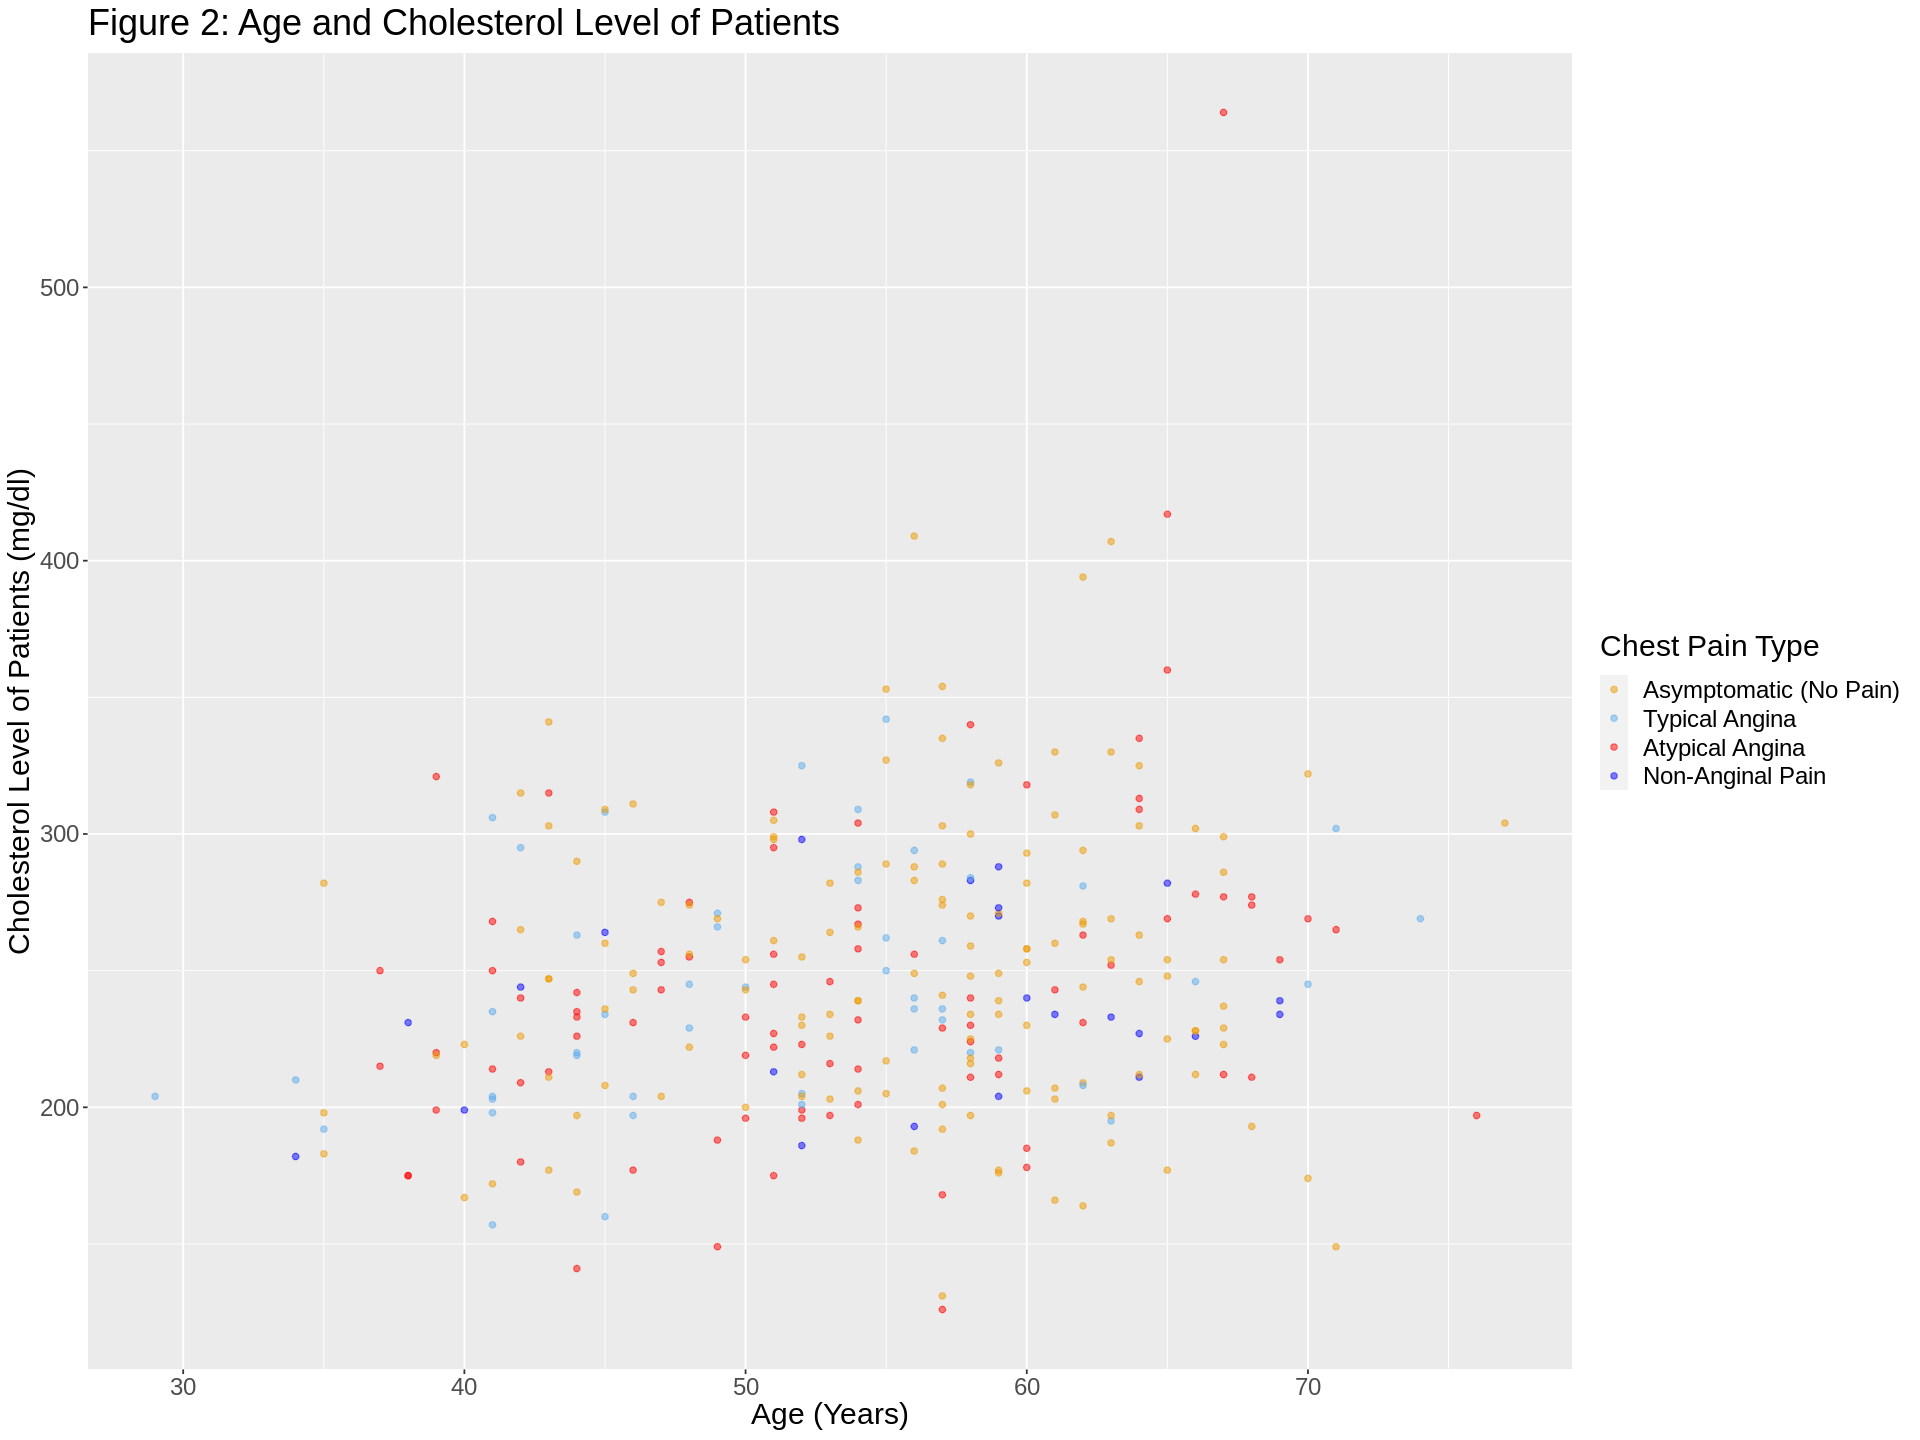

In [39]:
options(repr.plot.width= 16, repr.plot.height=12)
heart_plot <- heart %>%
  ggplot(aes(x = age, y = chol)) +
  geom_point(aes(color = cp), alpha = 0.5) +
  labs(x = "Age (Years)", y = "Cholesterol Level of Patients (mg/dl)", color = "Chest Pain Type") +
  scale_color_manual(labels = c("Asymptomatic (No Pain)", "Typical Angina", "Atypical Angina", "Non-Anginal Pain"),
                      values = c("orange2", "steelblue2", "red", "blue")) + 
  theme(text = element_text(size = 15)) +
  ggtitle("Figure 2: Age and Cholesterol Level of Patients") +
  theme(text = element_text(size = 18))
    
heart_plot

#### We split the heart data into training and testing sets. 

In [40]:
heart_split <- initial_split(heart, prop = 3/4, strata = cp)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

- K-nearest neighbors engine was created using the nearest_neighbor function, weight function was set to rectangular to calculate the linear distance from the estimation and true value, and the number of neighbors was tuned using tune(). Engine was set to be “kknn” to perform K Nearest Neighbor Analysis and mode was set to Classification.
- Recipe written with the target variable as cp (Chest Pain Type) and predictors chol (Cholesterol Level) and age using the training data (heart_training). All predictors were scaled and centered to ensure equal qualification in classifying testing set observations.
- Cross-Validation process was performed in a training set (heart_training) with 10 folds and strata to be cp (Chest Pain).
- A tibble with numbers 1 to 75 was created to represent possible k values, used in tune grid.
- Results were obtained using workflow function added with knn engine (knn_spec) and recipe (heart_recipe), tune grid was set to resamples the validation folds and a tibble of 75 values arranged from 1 to 75 was put into the grid. Metrics were collected using the collect_metrics function.
- A data frame (heart_cv_result)  including accuracy was obtained after filtering .metric equals to accuracy.
- A line plot with accuracy estimated vs. number of neighbors used was created using ggplot function and the resulting data frame from cross validations.

In [41]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

heart_recipe <- recipe(cp ~ chol + age, data = heart_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

heart_train_vfold <- vfold_cv(heart_training, v = 10, strata = cp)

k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 2))

heart_cv_result <- workflow() %>%
add_model(knn_spec) %>%
add_recipe(heart_recipe) %>%
tune_grid(resamples = heart_train_vfold, grid = k_vals) %>%
collect_metrics()

! Fold09: internal: No observations were detected in `truth` for level(s): '3'
Com...



In [42]:
accuracy <- heart_cv_result %>%
filter(.metric == "accuracy")
accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3840797,10,0.04483102,Model01
3,accuracy,multiclass,0.3965652,10,0.04668843,Model02
5,accuracy,multiclass,0.3492022,10,0.04342025,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
71,accuracy,multiclass,0.4908215,10,0.02866905,Model36
73,accuracy,multiclass,0.4771851,10,0.02566428,Model37
75,accuracy,multiclass,0.4771851,10,0.02566428,Model38


*Figure 3. table of k values and their accuracy.*

In [43]:
accuracy_slice <- arrange(accuracy, by = desc(mean)) %>% slice(1)
accuracy_slice

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
71,accuracy,multiclass,0.4908215,10,0.02866905,Model36


*Figure 4. K with the highest mean and accuracy.*

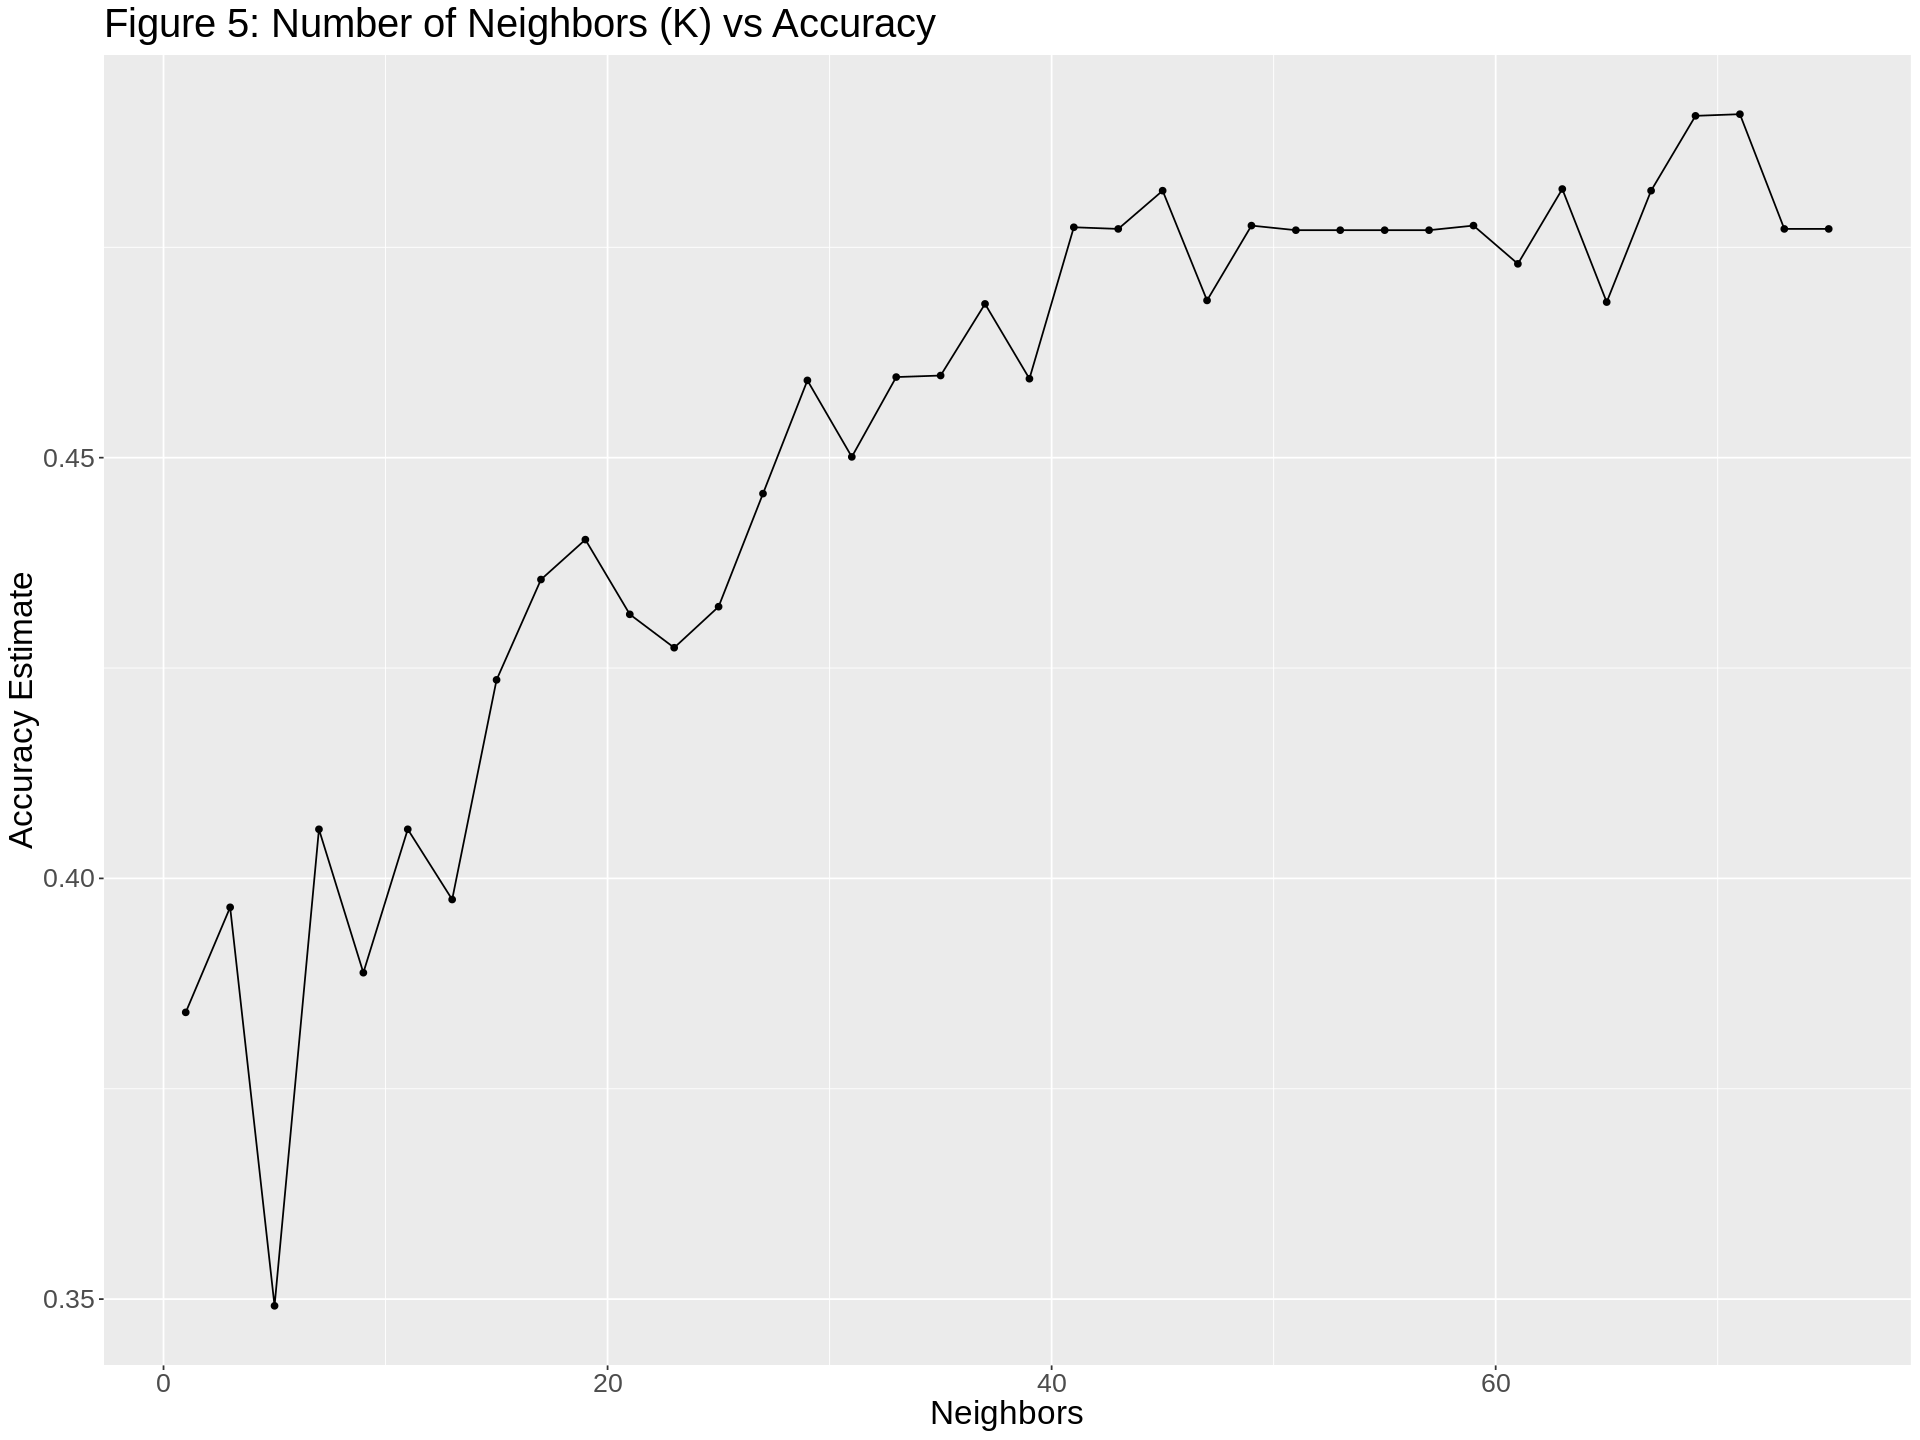

In [44]:
k_values_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
theme(text = element_text(size = 20)) + 
ggtitle("Figure 5: Number of Neighbors (K) vs Accuracy")
k_values_plot

- The best neighbor was calculated to be 71 with the highest accuracy of 47%, k = 71 was used to perform K Nearest Neighbor analysis on the testing data set with new knn engine (knn_spec_2) set neighbors to 71, engine set to “kknn” and mode was set to Classification.
- Fit function was used to transfer the workflow of knn engine (knn_spec_2) and recipe (heart_recipe) to fit the training data set (heart_training), and the trained model was used to assign classes to observations in the testing set (heart_testing) with the predict function.
- Resulting data frame was obtained using metrics function and confusion mattress was collected using conf_mat function where true value was set to cp (Chest Pain Type) from the testing set and estimated values were set to .pred_class from model classification.


In [36]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 71) %>%
set_engine("kknn") %>%
set_mode("classification")

heart_fit_2 <- workflow() %>%
add_model(knn_spec_2) %>%
add_recipe(heart_recipe) %>%
fit(heart_training)

heart_predict <- predict(heart_fit_2, heart_testing) %>%
bind_cols(heart_testing)

heart_metrics <- metrics(heart_predict, truth = cp, estimate = .pred_class)

heart_conf_mat <- heart_predict %>%
conf_mat(truth = cp, estimate = .pred_class)

heart_metrics

heart_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.472972973
kap,multiclass,-0.004524887


          Truth
Prediction  0  1  2  3
         0 32  9 19  5
         1  0  0  0  0
         2  5  1  3  0
         3  0  0  0  0

*Figure 6. K value and accuracy score and confusion matrix.* 

### Discussion: 
Accuracy obtained from the K Nearest Number Classification Algorithm was 47% (≤ 50%) indicating a weak relationship between the selected predictors and the target variable. This contradicted our expected result where angina and abnormal chest pain are closely related to higher cholesterol levels and old age. According to research conducted by A. Cordero and his fellow members in 2013, age and a history of heart failure in patients saw significant correlation with chest pain, while cholesterol levels revealed a weak association with the causation of chest pains. The findings suggest that both or one of the predictors has little impact on the target variable, which leads to failure of classification. By performing more K Nearest Neighbors Classification Algorithm iterations with different predictors involving age and previous peak (or heart strength/health), the level of correlation between predictors and the target variable could be determined and valued for chest pain type identification. Since chest pain is a common indicator of cardiovascular diseases and can occur in the lungs, esophagus, and chest muscles, studying the relation between different types of chest pain, their causes, and indications, can be advantageous to detecting disease earlier.

### Citation
- Angina - Symptoms and causes. (2020). Mayo Clinic; https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373#:~:text=Angina%20is%20caused%20by%20reduced,coronary%20artery%20disease%20(CAD).
- Cordero, A., Sirera, D., Carrillo, P., Lopez-Palop, R., Bertomeu-Gonzalez, V., Moreno-Arribas, J., Miralles, B., Masia, M. D., & Bertomeu-Martinez, V. (2013). Diagnostic and prognostic performance of the INTERHEART-cholesterol score in patients admitted for chest pain. European Heart Journal, 34(suppl 1), P1554–P1554. https://doi.org/10.1093/eurheartj/eht308.p1554
- Heart attack - Symptoms and causes. (2020). Mayo Clinic; https://www.mayoclinic.org/diseases-conditions/heart-attack/symptoms-causes/syc-20373106
- World. (2021, June 11). Cardiovascular diseases (CVDs). Who.int; World Health Organization:WHO. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

By: 
Amelie Lacey: 64044902, 
Betty Lin:
Riddhi Battu: 85855856